# A simple ripple carry adder on the QPU

In this notebook we implement a "simple" reversible binary adder. It is based on

*A new quantum ripple-carry addition circuit*, by 
Cuccaro, Draper, Kutin, and Moulton. See
https://arxiv.org/abs/quant-ph/0410184v1 .

The whole circuit is classical in the sense that we start and end in computational basis states and all gates simply perform classical not, controlled not, or doublely controled not.

In [1]:
import numpy as np
from pyquil.quil import Program

from pyquil.gates import *
from pyquil.api import get_qc
from forest_benchmarking.benchmarks.classical_logic_circuits.classical_reversible_logic_primitives import *
from scipy.special import comb
import time
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# noiseless QVM
qc = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=False)

# noisy QVM
noisy_qc = get_qc("9q-generic-noisy-qvm", as_qvm=True, noisy=True)


## Draw the noiseless qc topology

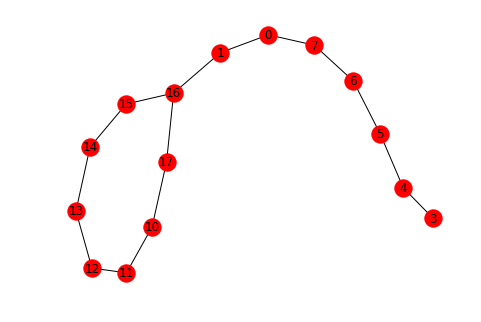

In [3]:
nx.draw(qc.qubit_topology(),with_labels=True)

## Start with 1+1=2 on a noiseless simulation

In [5]:
num_a = [0,1]
num_b = [0,1]
reg_a, reg_b, c, z = assign_registers_to_line_or_cycle(3, qc.qubit_topology(), len(num_a))
ckt = adder(num_a, num_b, reg_a, reg_b, c, z)
print(ckt)
exe = qc.compiler.native_quil_to_executable(ckt)
print(len(exe.program))
qc.run(exe)

X 5
X 4
CNOT 5 4
CNOT 5 3
CCNOT 3 4 5
CNOT 7 6
CNOT 7 5
CCNOT 5 6 7
CNOT 7 0
CCNOT 5 6 7
CNOT 7 5
CNOT 5 6
CCNOT 3 4 5
CNOT 5 3
CNOT 3 4
DECLARE ro BIT[3]
MEASURE 4 ro[2]
MEASURE 6 ro[1]
MEASURE 0 ro[0]

203


array([[0, 1, 0]])

## Draw the noisy qc topology

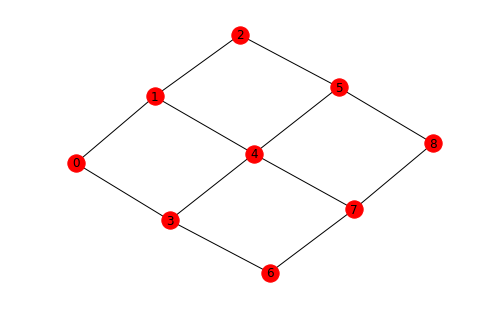

In [6]:
nx.draw(noisy_qc.qubit_topology(),with_labels=True)

## Now try 1+1=2 on a noisy qc

In [7]:
ckt = adder(num_a, num_b)
print(ckt)
exe = noisy_qc.compile(ckt)
print(len(exe.program))
noisy_qc.run(exe)

X 2
X 1
CNOT 2 1
CNOT 2 0
CCNOT 0 1 2
CNOT 4 3
CNOT 4 2
CCNOT 2 3 4
CNOT 4 5
CCNOT 2 3 4
CNOT 4 2
CNOT 2 3
CCNOT 0 1 2
CNOT 2 0
CNOT 0 1
DECLARE ro BIT[3]
MEASURE 1 ro[2]
MEASURE 3 ro[1]
MEASURE 5 ro[0]

8598


array([[0, 0, 1]])

## Try again, but first assign qubits in circuit diagram order

In [8]:
topology = noisy_qc.qubit_topology()
reg_a, reg_b, c, z = assign_registers_to_line_or_cycle(0, topology, len(num_a))
ckt = adder(num_a, num_b, reg_a, reg_b, c, z)
print(ckt)
exe = noisy_qc.compiler.native_quil_to_executable(ckt)
print(len(exe.program))
noisy_qc.run(exe)

X 6
X 3
CNOT 6 3
CNOT 6 0
CCNOT 0 3 6
CNOT 4 7
CNOT 4 6
CCNOT 6 7 4
CNOT 4 1
CCNOT 6 7 4
CNOT 4 6
CNOT 6 7
CCNOT 0 3 6
CNOT 6 0
CNOT 0 3
DECLARE ro BIT[3]
MEASURE 3 ro[2]
MEASURE 7 ro[1]
MEASURE 1 ro[0]

203


array([[0, 1, 0]])

In [17]:
from scipy.spatial.distance import hamming


from pyquil.unitary_tools import all_bitstrings





def average_n_bit_adder_performance(qc, n_bits, registers=None, in_x_basis=False, num_shots = 10, use_active_reset = True):
    """
    Find hamming weight distribution of errors relative to correct answer averaged over input strings.
    
    The default option is to compute this in the computational (aka Z) basis. By passing in
    CNOTfun and CCNOTfun as CNOT_X_basis and CCNOT_X_basis the computation happens in the X basis.
    
    :param n_bits: the number of bits of each of the equal-length summands.
    :returns wt: hamming weights from QPU or QVM
    """
    rel_hamming_weights = []
    # loop over all binary strings of length "n"
    for bits in all_bitstrings(2 * n_bits):
        # split the binary number into two numbers
        # which are the binary numbers the user wants to add.
        # They are written from (MSB .... LSB) = (a_n, ..., a_1, a_0)
        num_a = bits[:n_bits]
        num_b = bits[n_bits:]
        nums = (num_a, num_b)

        # add the numbers
        ans = sum([bit_array_to_int(num) for num in nums])
        ans_bits = int_to_bit_array(ans, n_bits + 1)
        
        add_prog = Program()
        if use_active_reset:
            add_prog += RESET()
        
        # create the program and compile appropriately
        if registers is None:
            add_prog = adder(num_a, num_b, in_x_basis=in_x_basis)
            add_prog.wrap_in_numshots_loop(num_shots)
            add_exe = qc.compile(add_prog)
        else:
            add_prog = adder(num_a, num_b, *registers, in_x_basis)
            add_prog.wrap_in_numshots_loop(num_shots)
            add_exe = qc.compiler.native_quil_to_executable(add_prog)
        
        # Run it on the QPU or QVM
        qpustart = time.time()
        results = qc.run(add_exe)
        qpuend = time.time()
        print('runtime: ' + str(qpuend - qpustart))
            
        # find average hamming weight between correct answer and QPU / QVM result
        count = 0
        wt = 0
        for result in results:
            wt += hamming(ans_bits, result)/num_shots
            if np.array_equal(ans_bits, result):
                count +=1
        rel_hamming_weights.append(wt)
            
        print('Pr(', bit_array_to_int(num_a), '+', bit_array_to_int(num_b),
              '=', ans, ') = ', count/num_shots)
    return rel_hamming_weights

In [18]:
n_bits = 2
registers = assign_registers_to_line_or_cycle(0, topology, n_bits)
average_n_bit_adder_performance(noisy_qc, n_bits, registers=registers)

runtime: 0.1556243896484375
Pr( 0 + 0 = 0 ) =  1.0
runtime: 0.15027856826782227
Pr( 0 + 1 = 1 ) =  0.9
runtime: 0.15701508522033691
Pr( 0 + 2 = 2 ) =  1.0
runtime: 0.157454252243042
Pr( 0 + 3 = 3 ) =  0.9
runtime: 0.15459465980529785
Pr( 1 + 0 = 1 ) =  0.9
runtime: 0.1442551612854004
Pr( 1 + 1 = 2 ) =  1.0
runtime: 0.16945099830627441
Pr( 1 + 2 = 3 ) =  0.9
runtime: 0.20545554161071777
Pr( 1 + 3 = 4 ) =  1.0
runtime: 0.229461669921875
Pr( 2 + 0 = 2 ) =  0.9
runtime: 0.20487308502197266
Pr( 2 + 1 = 3 ) =  0.8
runtime: 0.16241097450256348
Pr( 2 + 2 = 4 ) =  0.9
runtime: 0.15465140342712402
Pr( 2 + 3 = 5 ) =  0.7
runtime: 0.1647944450378418
Pr( 3 + 0 = 3 ) =  0.8
runtime: 0.16556525230407715
Pr( 3 + 1 = 4 ) =  0.9
runtime: 0.1472456455230713
Pr( 3 + 2 = 5 ) =  0.7
runtime: 0.15706181526184082
Pr( 3 + 3 = 6 ) =  0.9


[0.0,
 0.03333333333333333,
 0.0,
 0.03333333333333333,
 0.03333333333333333,
 0.0,
 0.03333333333333333,
 0.0,
 0.06666666666666667,
 0.13333333333333333,
 0.03333333333333333,
 0.1,
 0.13333333333333333,
 0.03333333333333333,
 0.1,
 0.03333333333333333]

# Addition in the Z (Computational) basis results

runtime: 1.3064579963684082
Pr(suc) = 0.25
runtime: 0.998553991317749
Pr(suc) = 0.25
runtime: 0.8788619041442871
Pr(suc) = 0.2
runtime: 0.725492000579834
Pr(suc) = 0.2


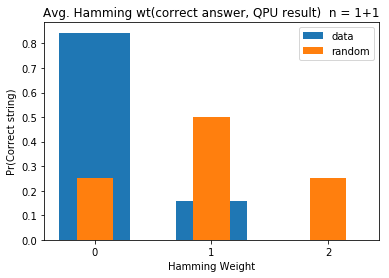

runtime: 1.8589229583740234
Pr(suc) = 0.2
runtime: 1.991332769393921
Pr(suc) = 0.125
runtime: 1.99714994430542
Pr(suc) = 0.2
runtime: 1.8624670505523682
Pr(suc) = 0.05
runtime: 1.8658502101898193
Pr(suc) = 0.075
runtime: 1.815424919128418
Pr(suc) = 0.125
runtime: 1.8163819313049316
Pr(suc) = 0.1
runtime: 1.886094093322754
Pr(suc) = 0.175
runtime: 1.7729802131652832
Pr(suc) = 0.125
runtime: 1.8846769332885742
Pr(suc) = 0.075
runtime: 1.8310699462890625
Pr(suc) = 0.25
runtime: 1.7677240371704102
Pr(suc) = 0.15
runtime: 1.8370187282562256
Pr(suc) = 0.15
runtime: 1.852219820022583
Pr(suc) = 0.1
runtime: 1.8766119480133057
Pr(suc) = 0.1
runtime: 1.805290937423706
Pr(suc) = 0.2


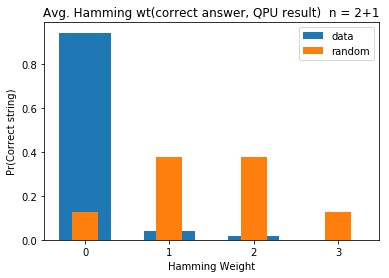

In [8]:
# If equal to 10,000  = 1% error
num_trials = 40 #000

avg_n = []
med_n = []
min_n = []
max_n = []
rand_n = []

for ndx in range(1,3):
    # length of binary string
    n=ndx
    
    bin_str = []
    bin_str = construct_all_possible_input_numbers(n)
    
    # find hamming weight distribution of errors relative to correct
    # answer averaged over all possible input strings
    wt = np.zeros((2**(2*n),num_trials))
    wt = average_adder_result_over_input_strings(bin_str,num_of_qubits)
    histy = construct_bit_flip_error_histogram(wt,n)
    hamming_wt = np.array([comb(n+1,x) for x in list(range(0,n+2))])
    hamming_dist = hamming_wt/sum(hamming_wt)

    # calculate statistics
    exp_average_hamming = np.average(histy,0)/num_trials
    avg_n.append(np.average(histy[0],0)/num_trials)
    med_n.append(np.median(histy[0],0)/num_trials)
    min_n.append(np.min(histy[0],0)/num_trials)
    max_n.append(np.max(histy[0],0)/num_trials)
    rand_n.append(hamming_dist[0])

    # some plotting
    weight_vec = list(np.arange(0,n+2))
    plt.bar(weight_vec,exp_average_hamming,width=0.61,align='center')
    plt.bar(weight_vec,hamming_dist,width=0.31,align='center')
    plt.xticks(weight_vec, list(range(0,n+2)))
    plt.xlabel('Hamming Weight')
    plt.ylabel('Pr(Correct string)' )
    plt.legend(['data','random'])
    plt.title('Avg. Hamming wt(correct answer, QPU result)' '  n = ' + str(n) + '+' +str(1))
    name = 'hamm_n_equal_' + str(n)
    plt.savefig(name+'.pdf', bbox_inches='tight')
    plt.show()

# Addition in the X basis results

runtime: 0.8560998439788818
Pr(suc) = 0.225
runtime: 0.837130069732666
Pr(suc) = 0.275
runtime: 0.7872509956359863
Pr(suc) = 0.25
runtime: 0.7553541660308838
Pr(suc) = 0.225


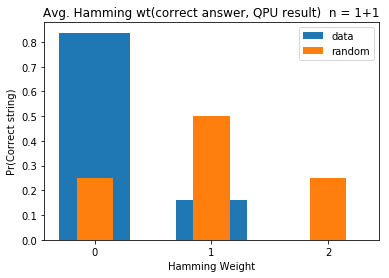

runtime: 1.9475767612457275
Pr(suc) = 0.1
runtime: 2.0232138633728027
Pr(suc) = 0.05
runtime: 2.120298385620117
Pr(suc) = 0.05
runtime: 1.879486083984375
Pr(suc) = 0.075
runtime: 1.9667320251464844
Pr(suc) = 0.125
runtime: 1.945770025253296
Pr(suc) = 0.05
runtime: 1.8539447784423828
Pr(suc) = 0.025
runtime: 1.9483740329742432
Pr(suc) = 0.1
runtime: 1.9713902473449707
Pr(suc) = 0.1
runtime: 1.8854248523712158
Pr(suc) = 0.125
runtime: 1.8954660892486572
Pr(suc) = 0.125
runtime: 1.878230094909668
Pr(suc) = 0.125
runtime: 1.889120101928711
Pr(suc) = 0.1
runtime: 1.886733055114746
Pr(suc) = 0.075
runtime: 1.894124984741211
Pr(suc) = 0.175
runtime: 1.8899500370025635
Pr(suc) = 0.075


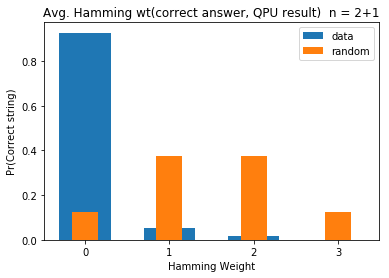

In [11]:
# If equal to 10,000  = 1% error
num_trials = 40 #000

avg_n = []
med_n = []
min_n = []
max_n = []
rand_n = []

for ndx in range(1,3):
    # length of binary string
    n=ndx
    
    bin_str = []
    bin_str = construct_all_possible_input_numbers(n)
    
    # find hamming weight distribution of errors relative to correct
    # answer averaged over all possible input strings
    wt = np.zeros((2**(2*n),num_trials))
    wt = average_adder_result_over_input_strings(bin_str, num_of_qubits, CNOT_X_basis, CCNOT_X_basis)
    histy = construct_bit_flip_error_histogram(wt,n)
    hamming_wt = np.array([comb(n+1,x) for x in list(range(0,n+2))])
    hamming_dist = hamming_wt/sum(hamming_wt)

    # calculate statistics
    exp_average_hamming = np.average(histy,0)/num_trials
    avg_n.append(np.average(histy[0],0)/num_trials)
    med_n.append(np.median(histy[0],0)/num_trials)
    min_n.append(np.min(histy[0],0)/num_trials)
    max_n.append(np.max(histy[0],0)/num_trials)
    rand_n.append(hamming_dist[0])

    # some plotting
    weight_vec = list(np.arange(0,n+2))
    plt.bar(weight_vec,exp_average_hamming,width=0.61,align='center')
    plt.bar(weight_vec,hamming_dist,width=0.31,align='center')
    plt.xticks(weight_vec, list(range(0,n+2)))
    plt.xlabel('Hamming Weight')
    plt.ylabel('Pr(Correct string)' )
    plt.legend(['data','random'])
    plt.title('Avg. Hamming wt(correct answer, QPU result)' '  n = ' + str(n) + '+' +str(1))
    name = 'hamm_n_equal_' + str(n)
    plt.savefig(name+'.pdf', bbox_inches='tight')
    plt.show()